In [ ]:
! pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# API to fectch dataset from kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kazanova/sentiment140")

print("Path to dataset files:", path)

100%|██████████| 80.9M/80.9M [00:00<00:00, 128MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kazanova/sentiment140/versions/2


In [ ]:
# importing all required libraries.
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
# downloading stopwords - words which don't reflect any message
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
print(stopwords.words('english'))   # these words are not needed for understanding of the message.

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
# DATA PROCESSING
# The dataset used below is downloaded from the kaggle.
# Description : The csv file contains the tweets uploaded in the twitter.
# The data contains columns like Date, time, tweets.
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding = 'ISO-8859-1')

In [ ]:
twitter_data.shape

(1599999, 6)

In [ ]:
twitter_data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
column_names = ['target', 'id', 'data', 'flag', 'user', 'text']
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',names = column_names, encoding = 'ISO-8859-1')

In [ ]:
twitter_data.head()

,target,id,data,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
twitter_data.isnull().sum()

,0
target,0
id,0
data,0
flag,0
user,0
text,0


In [ ]:
# target column distribution.
twitter_data['target'].value_counts()

,count
target,
0,800000
4,800000


In [ ]:
# changing the targets as 0 and 1.
twitter_data.replace({'target':{4:1}}, inplace = True)

In [ ]:
twitter_data['target'].value_counts()

,count
target,
0,800000
1,800000


Stemming - the process of reducing a word to its Root word
ex: actor, actress, acting = act

In [ ]:
port_stem = PorterStemmer()

In [ ]:
def stemming(content):
  stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
  stemmed_content = stemmed_content.lower()
  stemmed_content = stemmed_content.split()
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content)
  return stemmed_content

In [ ]:
twitter_data['stemmed_content'] = twitter_data['text'].apply(stemming)         #it take almost 50 min to complete stemming

In [ ]:
twitter_data.head()

,target,id,data,flag,user,text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [ ]:
import pandas as pd

# Assuming your DataFrame is called 'df'
twitter_data.to_csv('/content/stemming_data.csv', index=False)

In [ ]:
from google.colab import files
files.download('/content/stemming_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(twitter_data['stemmed_content'])

0          switchfoot http twitpic com zl awww bummer sho...
1          upset updat facebook text might cri result sch...
2          kenichan dive mani time ball manag save rest g...
3                            whole bodi feel itchi like fire
4                              nationwideclass behav mad see
                                 ...                        
1599995                           woke school best feel ever
1599996    thewdb com cool hear old walt interview http b...
1599997                         readi mojo makeov ask detail
1599998    happi th birthday boo alll time tupac amaru sh...
1599999    happi charitytuesday thenspcc sparkschar speak...
Name: stemmed_content, Length: 1600000, dtype: object


In [ ]:
print(twitter_data['target'])

0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: target, Length: 1600000, dtype: int64


In [ ]:
X = twitter_data['stemmed_content'].values
Y = twitter_data['target'].values

In [ ]:
print(X)

['switchfoot http twitpic com zl awww bummer shoulda got david carr third day'
 'upset updat facebook text might cri result school today also blah'
 'kenichan dive mani time ball manag save rest go bound' ...
 'readi mojo makeov ask detail'
 'happi th birthday boo alll time tupac amaru shakur'
 'happi charitytuesday thenspcc sparkschar speakinguph h']


In [ ]:
print(Y)

[0 0 0 ... 1 1 1]


In [ ]:
# splitting the data to training data and testing data.
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, stratify=Y, random_state = 2)

In [ ]:
print(X.shape, X_train.shape, X_test.shape)

(1600000,) (1280000,) (320000,)


In [ ]:
print(X_train)

['watch saw iv drink lil wine' 'hatermagazin'
 'even though favourit drink think vodka coke wipe mind time think im gonna find new drink'
 ... 'eager monday afternoon'
 'hope everyon mother great day wait hear guy store tomorrow'
 'love wake folger bad voic deeper']


In [ ]:
print(X_test)

['mmangen fine much time chat twitter hubbi back summer amp tend domin free time'
 'ah may show w ruth kim amp geoffrey sanhueza'
 'ishatara mayb bay area thang dammit' ...
 'destini nevertheless hooray member wonder safe trip' 'feel well'
 'supersandro thank']


In [ ]:
# converting text into the numerical data using vectorizer.
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
print(X_train)

  (0, 436713)	0.27259876264838384
  (0, 354543)	0.3588091611460021
  (0, 185193)	0.5277679060576009
  (0, 109306)	0.3753708587402299
  (0, 235045)	0.41996827700291095
  (0, 443066)	0.4484755317023172
  (1, 160636)	1.0
  (2, 109306)	0.4591176413728317
  (2, 124484)	0.1892155960801415
  (2, 407301)	0.18709338684973031
  (2, 129411)	0.29074192727957143
  (2, 406399)	0.32105459490875526
  (2, 433560)	0.3296595898028565
  (2, 77929)	0.31284080750346344
  (2, 443430)	0.3348599670252845
  (2, 266729)	0.24123230668976975
  (2, 409143)	0.15169282335109835
  (2, 178061)	0.1619010109445149
  (2, 150715)	0.18803850583207948
  (2, 132311)	0.2028971570399794
  (2, 288470)	0.16786949597862733
  (3, 406399)	0.29029991238662284
  (3, 158711)	0.4456939372299574
  (3, 151770)	0.278559647704793
  (3, 56476)	0.5200465453608686
  :	:
  (1279996, 318303)	0.21254698865277744
  (1279996, 434014)	0.27189450523324465
  (1279996, 390130)	0.2206474219107611
  (1279996, 373144)	0.35212500999832036
  (1279996, 23807

In [ ]:
print(X_test)

  (0, 15110)	0.1719352837797837
  (0, 31168)	0.1624772418052177
  (0, 67828)	0.26800375270827315
  (0, 106069)	0.36555450010904555
  (0, 132364)	0.255254889555786
  (0, 138164)	0.23688292264071406
  (0, 171378)	0.2805816206356074
  (0, 271016)	0.45356623916588285
  (0, 279082)	0.17825180109103442
  (0, 388348)	0.2198507607206174
  (0, 398906)	0.34910438732642673
  (0, 409143)	0.3143047059807971
  (0, 420984)	0.17915624523539805
  (1, 6463)	0.30733520460524466
  (1, 15110)	0.211037449588008
  (1, 145393)	0.575262969264869
  (1, 217562)	0.40288153995289894
  (1, 256777)	0.28751585696559306
  (1, 348135)	0.4739279595416274
  (1, 366203)	0.24595562404108307
  (2, 22532)	0.3532582957477176
  (2, 34401)	0.37916255084357414
  (2, 89448)	0.36340369428387626
  (2, 183312)	0.5892069252021465
  (2, 256834)	0.2564939661498776
  :	:
  (319994, 443794)	0.2782185641032538
  (319995, 107868)	0.33399349737546963
  (319995, 109379)	0.3020896484890833
  (319995, 155493)	0.2770682832971669
  (319995, 2133

Training the Model

In [ ]:
# Logistic Regression
model = LogisticRegression(max_iter=1000)

In [ ]:
model.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

Model evaluation

In [ ]:
# Accuracy Score on training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train, X_train_prediction)

In [ ]:
print('Accuracy score : ', training_data_accuracy)

Accuracy score :  0.79871953125


In [ ]:
# Accuracy Score on testing data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(Y_test, X_test_prediction)

In [ ]:
print('Accuracy score : ', test_data_accuracy)

Accuracy score :  0.77668125


Saving the Training Model

In [ ]:
import pickle

In [ ]:
filename = 'trained_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
# loading the saved model.
loaded_model = pickle.load(open('/content/trained_model.sav', 'rb'))

In [ ]:
# Save the vectorizer as a pickle file
vectorizer_filename = 'vectorizer_pickle1.pkl'
pickle.dump(vectorizer, open(vectorizer_filename, 'wb'))

In [ ]:
# loading the saved model.
loaded_model = pickle.load(open('/content/vectorizer_pickle1.pkl', 'rb'))

In [ ]:
X_new = X_test[3]
print(Y_test[3])

prediction = model.predict(X_new)
print(prediction)
if(prediction[0] == 0):
  print('Negative tweet')
else:
  print('Positive tweet')

0
[0]
Negative tweet


In [ ]:
import pickle
with open('model_pickle1', 'wb') as f:
  pickle.dump(model, f)

In [ ]:
# loading pickle
with open('model_pickle1', 'rb') as f:
  mp = pickle.load(f)

In [ ]:
# Save the vectorizer as a pickle file
vectorizer_filename = 'vectorizer_pickle1.pkl'
pickle.dump(vectorizer, open(vectorizer_filename, 'wb'))

In [ ]:
mp

LogisticRegression(max_iter=1000)

In [ ]:
mp.predict(X_new)

array([0])

In [ ]:
X_new = X_test[3]
print(Y_test[3])

prediction = model.predict(X_new)
print(prediction)
if(prediction[0] == 0):
  print('Negative tweet')
else:
  print('Positive tweet')

0
[0]
Negative tweet


In [ ]:
# Load the model
import pickle
model = pickle.load(open('trained_model.sav', 'rb'))

# Inspect properties (example for Logistic Regression)
print("Model Coefficients:", model.coef_)
print("Model Intercept:", model.intercept_)


Model Coefficients: [[-1.39335053 -1.60463829 -0.39963216 ...  0.3080497  -0.07891573
  -0.040284  ]]
Model Intercept: [0.43270804]


Using the saved pickle files, the model below allows you to input text and determines whether it is a positive or negative tweet

In [ ]:
import pickle
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
# import nltk
# nltk.download('stopwords')
# Load the trained model
model_filename = '/content/model_pickle1'
loaded_model = pickle.load(open(model_filename, 'rb'))
# Load the vectorizer
vectorizer_filename = '/content/vectorizer_pickle1.pkl'
vectorizer = pickle.load(open(vectorizer_filename, 'rb'))
# Initialize the stemmer
port_stem = PorterStemmer()
# Define the stemming function
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)  # Remove non-alphabetic characters
    stemmed_content = stemmed_content.lower()  # Convert to lowercase
    stemmed_content = stemmed_content.split()  # Tokenize

    # Keep essential stopwords like 'not', 'no'
    stopword_list = set(stopwords.words('english')) - {'not', 'no'}
    stemmed_content = [
        port_stem.stem(word) for word in stemmed_content if word not in stopword_list
    ]  # Stem and remove stopwords

    stemmed_content = ' '.join(stemmed_content)  # Rejoin tokens
    return stemmed_content

# Function to predict sentiment for new text
def predict_new_text(text):
    # Preprocess the new text
    preprocessed_text = stemming(text)
    print("Preprocessed text:", preprocessed_text)  # Debugging output

    # Transform the text using the vectorizer
    vectorized_text = vectorizer.transform([preprocessed_text])
    print("Vectorized text shape:", vectorized_text.shape)  # Debugging output

    # Predict sentiment
    prediction = loaded_model.predict(vectorized_text)

    # Return the result
    if prediction[0] == 0:
        return 0
    else:
        return 1

# Example usage with user input
new_text = input("Enter a tweet: ")
result = predict_new_text(new_text)
print(result)
if result == 0:
    print("Negative tweet")
else:
    print("Positive tweet")

Enter a tweet: Zomato is collaborated with Blinkit, so stock price of Zomato may increase
Preprocessed text: zomato collabor blinkit stock price zomato may increas
Vectorized text shape: (1, 461488)
1
Positive tweet


In [ ]:
pip install tweepy praw telethon pandas numpy matplotlib seaborn scikit-learn textblob vaderSentiment transformers jupyter


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.2/702.2 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.8 MB/s eta 0:00:00
  Created wheel for pyaes: filename=pyaes-1.6.1-py3-none-any.whl size=26346 sha256=

In [ ]:
pip install tweepy

In [ ]:
pip install textblob

In [ ]:
import subprocess

subprocess.run(["python", "-m", "textblob.download_corpora"])

CompletedProcess(args=['python', '-m', 'textblob.download_corpora'], returncode=0)

In [ ]:
pip show tweepy


Name: tweepy
Version: 4.14.0
Summary: Twitter library for Python
Home-page: https://www.tweepy.org/
Author: Joshua Roesslein
Author-email: tweepy@googlegroups.com
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: oauthlib, requests, requests-oauthlib
Required-by: 


Scraping from Twitter API

In [ ]:
import tweepy
from textblob import TextBlob
import re

class TwitterClient(object):
    def __init__(self):
        '''
        Class constructor or initialization method.
        '''
        # Bearer Token from Twitter Developer Portal
        self.bearer_token = 'AAAAAAAAAAAAAAAAAAAAAAX%2BxAEAAAAAGM9ZpqwUU0gUw0OcnD%2F7gmRWzZc%3DIxCyVu3xKch56FygOSPYfOGbyigThzkNwxGfqgeXcYd1IYZa6W'

        try:
            # Initialize Tweepy Client for API v2
            self.client = tweepy.Client(bearer_token=self.bearer_token)
        except Exception as e:
            print(f"Error: Authentication Failed - {e}")

    def clean_tweet(self, tweet):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

    def get_tweet_sentiment(self, tweet):
        '''
        Utility function to classify sentiment of passed tweet
        using textblob's sentiment method
        '''
        analysis = TextBlob(self.clean_tweet(tweet))
        if analysis.sentiment.polarity > 0:
            return 'positive'
        elif analysis.sentiment.polarity == 0:
            return 'neutral'
        else:
            return 'negative'

    def get_tweets(self, query, count=10):
        '''
        Main function to fetch tweets and parse them.
        '''
        tweets = []

        try:
            # Fetch tweets using Twitter API v2
            response = self.client.search_recent_tweets(query=query, max_results=count, tweet_fields=["text"])
            fetched_tweets = response.data

            if not fetched_tweets:
                print("No tweets found for the query.")
                return []

            for tweet in fetched_tweets:
                parsed_tweet = {'text': tweet.text, 'sentiment': self.get_tweet_sentiment(tweet.text)}
                tweets.append(parsed_tweet)

            return tweets

        except tweepy.errors.TweepyException as e:
            print(f"Error: {e}")
            return []

def main():
    # Creating object of TwitterClient Class
    api = TwitterClient()
    # Calling function to get tweets
    tweets = api.get_tweets(query='Zomato Stock price', count=10)

    if not tweets:
        print("No tweets retrieved.")
        return []

    # Picking positive tweets from tweets
    ptweets = [tweet for tweet in tweets if tweet['sentiment'] == 'positive']
    # Store positive tweets in a global variable for later use
    global positive_tweets_text
    positive_tweets_text = [tweet['text'] for tweet in ptweets]

    # Percentage of positive tweets
    print("Positive tweets percentage: {} %".format(100 * len(ptweets) / len(tweets)))
    # Picking negative tweets from tweets
    ntweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negative']
    # Percentage of negative tweets
    print("Negative tweets percentage: {} %".format(100 * len(ntweets) / len(tweets)))
    # Percentage of neutral tweets
    print("Neutral tweets percentage: {} %".format(100 * (len(tweets) - len(ntweets) - len(ptweets)) / len(tweets)))

    # Printing first 5 positive tweets
    print("\n\nPositive tweets:")
    for tweet in ptweets[:5]:
        print(tweet['text'])

    # Printing first 5 negative tweets
    print("\n\nNegative tweets:")
    for tweet in ntweets[:5]:
        print(tweet['text'])

    # Return positive tweets for future use
    return positive_tweets_text

# Call main and store positive tweets in a variable
if __name__ == "__main__":
    positive_tweets = main()


Positive tweets percentage: 80.0 %
Negative tweets percentage: 20.0 %
Neutral tweets percentage: 0.0 %


Positive tweets:
RT @NDTVProfitIndia: I think that #Zomato is a multibagger in the making. I won't be surprised if the stock trades at Rs 800 in five years,…
Swiggy Q2 Results LIVE: Stock falls after food delivery aggregator remains loss making https://t.co/EMaAJ5xdDS
#StockMarket Today LIVE Updates : #SENSEX 500 अंक उछला - #NIFTY 24400 के पार; BANK, OIL में 1% से अधिक की बढ़त - ADANI PORTS, ONGC टॉप गेनर्स | Share Price Target

#StocksToWatch 

https://t.co/3mPgH8iJC7
Then Launched the #District App and these live shows. 

And continuous amazing feature updates by Zomato are a tight slap on the face of people mocking the product. 

Long back when Zomato's stock price was Rs. 45 I wrote a detailed article doing product analysis. 

@deepigoyal
Stock Market Today LIVE Updates : हरे निशान पर खुला बाज़ार ! SENSEX 80,400 के करीब - NIFTY 24,300 के ऊपर; Metal चमका - FMCG लुढ़का | Share Pri

The below is the final code created by combining above created model and scrapping data using twitter.

In [ ]:
############################################################################ Final Model #######################################################################################

In [ ]:
import tweepy
from textblob import TextBlob
import re
import pickle
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

class TwitterClient(object):
    def __init__(self):
        '''
        Class constructor or initialization method.
        '''
        # Bearer Token from Twitter Developer Portal
        self.bearer_token = 'AAAAAAAAAAAAAAAAAAAAAAX%2BxAEAAAAAGM9ZpqwUU0gUw0OcnD%2F7gmRWzZc%3DIxCyVu3xKch56FygOSPYfOGbyigThzkNwxGfqgeXcYd1IYZa6W'

        try:
            # Initialize Tweepy Client for API v2
            self.client = tweepy.Client(bearer_token=self.bearer_token)
        except Exception as e:
            print(f"Error: Authentication Failed - {e}")

    def clean_tweet(self, tweet):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

    def get_tweet_sentiment(self, tweet):
        '''
        Utility function to classify sentiment of passed tweet
        using textblob's sentiment method
        '''
        analysis = TextBlob(self.clean_tweet(tweet))
        if analysis.sentiment.polarity > 0:
            return 'positive'
        elif analysis.sentiment.polarity == 0:
            return 'neutral'
        else:
            return 'negative'

    def get_tweets(self, query, count=10):
        '''
        Main function to fetch tweets and parse them.
        '''
        tweets = []

        try:
            # Fetch tweets using Twitter API v2
            response = self.client.search_recent_tweets(query=query, max_results=count, tweet_fields=["text"])
            fetched_tweets = response.data

            if not fetched_tweets:
                print("No tweets found for the query.")
                return []

            for tweet in fetched_tweets:
                parsed_tweet = {'text': tweet.text, 'sentiment': self.get_tweet_sentiment(tweet.text)}
                tweets.append(parsed_tweet)

            return tweets

        except tweepy.errors.TweepyException as e:
            print(f"Error: {e}")
            return []

def main():
    # Creating object of TwitterClient Class
    api = TwitterClient()
    # Calling function to get tweets
    tweets = api.get_tweets(query='Zomato Stock price', count=100)

    if not tweets:
        print("No tweets retrieved.")
        return []

    # Picking positive tweets from tweets
    ptweets = [tweet for tweet in tweets if tweet['sentiment'] == 'positive']
    # Store positive tweets in a global variable for later use
    global positive_tweets_text
    positive_tweets_text = [tweet['text'] for tweet in ptweets]

    # Printing percentages of sentiment in tweets
    print("Positive tweets percentage: {} %".format(100 * len(ptweets) / len(tweets)))
    ntweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negative']
    print("Negative tweets percentage: {} %".format(100 * len(ntweets) / len(tweets)))
    print("Neutral tweets percentage: {} %".format(100 * (len(tweets) - len(ntweets) - len(ptweets)) / len(tweets)))

    return positive_tweets_text

# Load the trained model and vectorizer
model_filename = '/content/model_pickle1'  # Update path
vectorizer_filename = '/content/vectorizer_pickle1.pkl'  # Update path
loaded_model = pickle.load(open(model_filename, 'rb'))
vectorizer = pickle.load(open(vectorizer_filename, 'rb'))

# Initialize the stemmer
port_stem = PorterStemmer()

# Define the stemming function
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)  # Remove non-alphabetic characters
    stemmed_content = stemmed_content.lower()  # Convert to lowercase
    stemmed_content = stemmed_content.split()  # Tokenize

    # Keep essential stopwords like 'not', 'no'
    stopword_list = set(stopwords.words('english')) - {'not', 'no'}
    stemmed_content = [
        port_stem.stem(word) for word in stemmed_content if word not in stopword_list
    ]  # Stem and remove stopwords

    stemmed_content = ' '.join(stemmed_content)  # Rejoin tokens
    return stemmed_content

# Function to predict sentiment for new text
def predict_new_text(text):
    # Preprocess the new text
    preprocessed_text = stemming(text)

    # Transform the text using the vectorizer
    vectorized_text = vectorizer.transform([preprocessed_text])

    # Predict sentiment
    prediction = loaded_model.predict(vectorized_text)

    if prediction[0] == 0:
        return "Negative tweet"
    else:
        return "Positive tweet"

# Combine the main function with model prediction
def investment_recommendation():
    positive_tweets = main()

    # If no positive tweets, recommend not to invest
    if not positive_tweets:
        return "No recent sentiment data for Zomato. Cannot predict investment recommendation."

    positive_count = 0
    negative_count = 0

    # Analyze each positive tweet and predict sentiment using model
    for tweet in positive_tweets:
        result = predict_new_text(tweet)
        if result == "Positive tweet":
            positive_count += 1
        else:
            negative_count += 1

    # Calculate the investment recommendation based on sentiment analysis
    if positive_count > negative_count:
        return 1
    else:
        return 0

# Call the investment recommendation function
if __name__ == "__main__":
    recommendation = investment_recommendation()
    print(recommendation)
    if(recommendation == 1):
      print("Based on recent positive sentiment, it's a good time to invest in Zomato.")
    else:
      print("Based on recent negative sentiment, it's not recommended to invest in Zomato.")


Positive tweets percentage: 63.1578947368421 %
Negative tweets percentage: 15.789473684210526 %
Neutral tweets percentage: 21.05263157894737 %
1
Based on recent positive sentiment, it's a good time to invest in Zomato.


this variable "recommendation" is used to plot the increase or decrease of the stock price.

In [ ]:
import yfinance as yf

# Download Zomato stock data from NSE
data = yf.download("ZOMATO.NS", start="2019-12-04", end="2024-12-03", interval="1mo")

# Save to a CSV
data.to_csv("Zomato_Stock_Data.csv")

print("Dataset saved as Zomato_Stock_Data.csv")


[*********************100%***********************]  1 of 1 completed

Dataset saved as Zomato_Stock_Data.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df_zomato = pd.read_csv('/content/Zomato_Stock_Data.csv')

In [ ]:
df_zomato.dtypes

,0
Price,object
Adj Close,object
Close,object
High,object
Low,object
Open,object
Volume,object


In [ ]:
df_zomato.head()

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,ZOMATO.NS,ZOMATO.NS,ZOMATO.NS,ZOMATO.NS,ZOMATO.NS,ZOMATO.NS
1,Date,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-08-01 00:00:00+00:00,134.5500030517578,134.5500030517578,141.4499969482422,120.5,135.75,907715974
3,2021-09-01 00:00:00+00:00,136.60000610351562,136.60000610351562,152.75,130.6999969482422,134.5500030517578,638430092
4,2021-10-01 00:00:00+00:00,131.5500030517578,131.5500030517578,146.14999389648438,130.5,137.3000030517578,213381098


In [ ]:
df_zomato_cleaned = df_zomato.iloc[2:].reset_index(drop=True)

# Set the 'Date' column as the index, and convert it to datetime
df_zomato_cleaned['Date'] = pd.to_datetime(df_zomato_cleaned['Price'])
df_zomato_cleaned.set_index('Date', inplace=True)

# Round all numerical columns to one decimal place
df_zomato_cleaned = df_zomato_cleaned.round(1)

# Verify the cleaned DataFrame
print(df_zomato_cleaned.head())

                                               Price           Adj Close  \
Date                                                                       
2021-08-01 00:00:00+00:00  2021-08-01 00:00:00+00:00   134.5500030517578   
2021-09-01 00:00:00+00:00  2021-09-01 00:00:00+00:00  136.60000610351562   
2021-10-01 00:00:00+00:00  2021-10-01 00:00:00+00:00   131.5500030517578   
2021-11-01 00:00:00+00:00  2021-11-01 00:00:00+00:00   152.5500030517578   
2021-12-01 00:00:00+00:00  2021-12-01 00:00:00+00:00  137.39999389648438   

                                        Close                High  \
Date                                                                
2021-08-01 00:00:00+00:00   134.5500030517578   141.4499969482422   
2021-09-01 00:00:00+00:00  136.60000610351562              152.75   
2021-10-01 00:00:00+00:00   131.5500030517578  146.14999389648438   
2021-11-01 00:00:00+00:00   152.5500030517578               169.0   
2021-12-01 00:00:00+00:00  137.39999389648438  157.89

In [ ]:
df_zomato_cleaned

,Price,Adj Close,Close,High,Low,Open,Volume
0,2021-08-01 00:00:00+00:00,134.5500030517578,134.5500030517578,141.4499969482422,120.5,135.75,907715974
1,2021-09-01 00:00:00+00:00,136.60000610351562,136.60000610351562,152.75,130.6999969482422,134.5500030517578,638430092
2,2021-10-01 00:00:00+00:00,131.5500030517578,131.5500030517578,146.14999389648438,130.5,137.3000030517578,213381098
3,2021-11-01 00:00:00+00:00,152.5500030517578,152.5500030517578,169.0,127.5,133.60000610351562,1198862022
4,2021-12-01 00:00:00+00:00,137.39999389648438,137.39999389648438,157.89999389648438,124.5999984741211,153.0,580715216
5,2022-01-01 00:00:00+00:00,90.4000015258789,90.4000015258789,142.4499969482422,84.1500015258789,139.6999969482422,767874706
6,2022-02-01 00:00:00+00:00,79.94999694824219,79.94999694824219,99.75,75.75,91.75,530820223
7,2022-03-01 00:00:00+00:00,82.30000305175781,82.30000305175781,88.69999694824219,75.5,79.94999694824219,412080460
8,2022-04-01 00:00:00+00:00,71.75,71.75,88.30000305175781,71.0999984741211,82.0999984741211,331374818
9,2022-05-01 00:00:00+00:00,74.6500015258789,74.6500015258789,77.69999694824219,50.04999923706055,71.75,1351377679


In [ ]:
df_zomato = df_zomato_cleaned

In [ ]:
df_zomato.head()

,Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2021-08-01 00:00:00+00:00,2021-08-01 00:00:00+00:00,134.5500030517578,134.5500030517578,141.4499969482422,120.5,135.75,907715974
2021-09-01 00:00:00+00:00,2021-09-01 00:00:00+00:00,136.60000610351562,136.60000610351562,152.75,130.6999969482422,134.5500030517578,638430092
2021-10-01 00:00:00+00:00,2021-10-01 00:00:00+00:00,131.5500030517578,131.5500030517578,146.14999389648438,130.5,137.3000030517578,213381098
2021-11-01 00:00:00+00:00,2021-11-01 00:00:00+00:00,152.5500030517578,152.5500030517578,169.0,127.5,133.60000610351562,1198862022
2021-12-01 00:00:00+00:00,2021-12-01 00:00:00+00:00,137.39999389648438,137.39999389648438,157.89999389648438,124.5999984741211,153.0,580715216


In [ ]:
columns_to_round = ["Adj Close", "Close", "High", "Low","Open"]
df_zomato[columns_to_round] = df_zomato[columns_to_round].round(1)

In [ ]:
df_zomato.dtypes

,0
Price,object
Adj Close,object
Close,object
High,object
Low,object
Open,object
Volume,object


In [ ]:
df_zomato.head()

,Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2021-08-01 00:00:00+00:00,2021-08-01 00:00:00+00:00,134.5500030517578,134.5500030517578,141.4499969482422,120.5,135.75,907715974
2021-09-01 00:00:00+00:00,2021-09-01 00:00:00+00:00,136.60000610351562,136.60000610351562,152.75,130.6999969482422,134.5500030517578,638430092
2021-10-01 00:00:00+00:00,2021-10-01 00:00:00+00:00,131.5500030517578,131.5500030517578,146.14999389648438,130.5,137.3000030517578,213381098
2021-11-01 00:00:00+00:00,2021-11-01 00:00:00+00:00,152.5500030517578,152.5500030517578,169.0,127.5,133.60000610351562,1198862022
2021-12-01 00:00:00+00:00,2021-12-01 00:00:00+00:00,137.39999389648438,137.39999389648438,157.89999389648438,124.5999984741211,153.0,580715216


In [ ]:
columns_to_convert = ["Price", "Adj Close", "Close", "High", "Low", "Open", "Volume"]
df_zomato[columns_to_convert] = df_zomato[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Round specific columns to 1 decimal place
columns_to_round = ["Adj Close", "Close", "High", "Low", "Open"]
df_zomato[columns_to_round] = df_zomato[columns_to_round].round(1)

# Display the cleaned DataFrame
print(df_zomato)

                           Price  Adj Close  Close   High    Low   Open  \
Date                                                                      
2021-08-01 00:00:00+00:00    NaN      134.6  134.6  141.4  120.5  135.8   
2021-09-01 00:00:00+00:00    NaN      136.6  136.6  152.8  130.7  134.6   
2021-10-01 00:00:00+00:00    NaN      131.6  131.6  146.1  130.5  137.3   
2021-11-01 00:00:00+00:00    NaN      152.6  152.6  169.0  127.5  133.6   
2021-12-01 00:00:00+00:00    NaN      137.4  137.4  157.9  124.6  153.0   
2022-01-01 00:00:00+00:00    NaN       90.4   90.4  142.4   84.2  139.7   
2022-02-01 00:00:00+00:00    NaN       79.9   79.9   99.8   75.8   91.8   
2022-03-01 00:00:00+00:00    NaN       82.3   82.3   88.7   75.5   79.9   
2022-04-01 00:00:00+00:00    NaN       71.8   71.8   88.3   71.1   82.1   
2022-05-01 00:00:00+00:00    NaN       74.7   74.7   77.7   50.0   71.8   
2022-06-01 00:00:00+00:00    NaN       53.8   53.8   79.8   53.3   75.4   
2022-07-01 00:00:00+00:00

In [ ]:
df_zomato.dtypes

,0
Price,float64
Adj Close,float64
Close,float64
High,float64
Low,float64
Open,float64
Volume,int64


In [ ]:
df_zomato.head()

,Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2021-08-01 00:00:00+00:00,NaN,134.6,134.6,141.4,120.5,135.8,907715974
2021-09-01 00:00:00+00:00,NaN,136.6,136.6,152.8,130.7,134.6,638430092
2021-10-01 00:00:00+00:00,NaN,131.6,131.6,146.1,130.5,137.3,213381098
2021-11-01 00:00:00+00:00,NaN,152.6,152.6,169.0,127.5,133.6,1198862022
2021-12-01 00:00:00+00:00,NaN,137.4,137.4,157.9,124.6,153.0,580715216


In [ ]:
len(df_zomato)

41

In [ ]:
df_zomato

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2021-08-01 00:00:00+00:00,134.6,134.6,141.4,120.5,135.8,907715974
2021-09-01 00:00:00+00:00,136.6,136.6,152.8,130.7,134.6,638430092
2021-10-01 00:00:00+00:00,131.6,131.6,146.1,130.5,137.3,213381098
2021-11-01 00:00:00+00:00,152.6,152.6,169.0,127.5,133.6,1198862022
2021-12-01 00:00:00+00:00,137.4,137.4,157.9,124.6,153.0,580715216
2022-01-01 00:00:00+00:00,90.4,90.4,142.4,84.2,139.7,767874706
2022-02-01 00:00:00+00:00,79.9,79.9,99.8,75.8,91.8,530820223


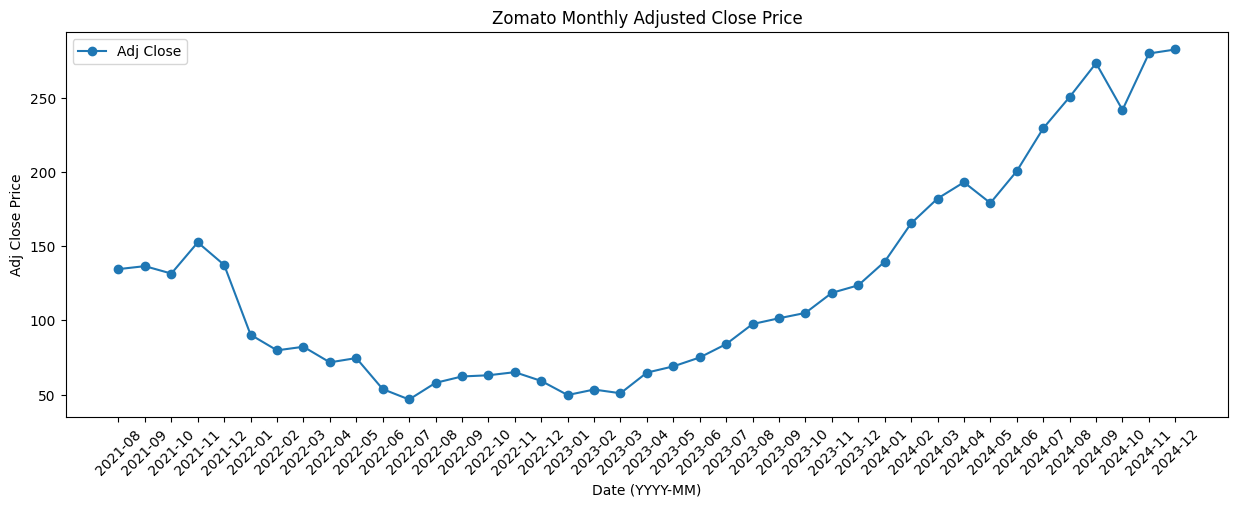

In [ ]:
# Plot the data (example: Adj Close)
plt.figure(figsize=(15, 5))
plt.plot(df_zomato.index, df_zomato['Adj Close'], marker='o', label='Adj Close')

# Add labels and title
plt.xlabel("Date (YYYY-MM)")
plt.ylabel("Adj Close Price")
plt.title("Zomato Monthly Adjusted Close Price")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()

<ipython-input-176-c086804a7567>:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(last_date, periods=2, freq='M')  # One month ahead


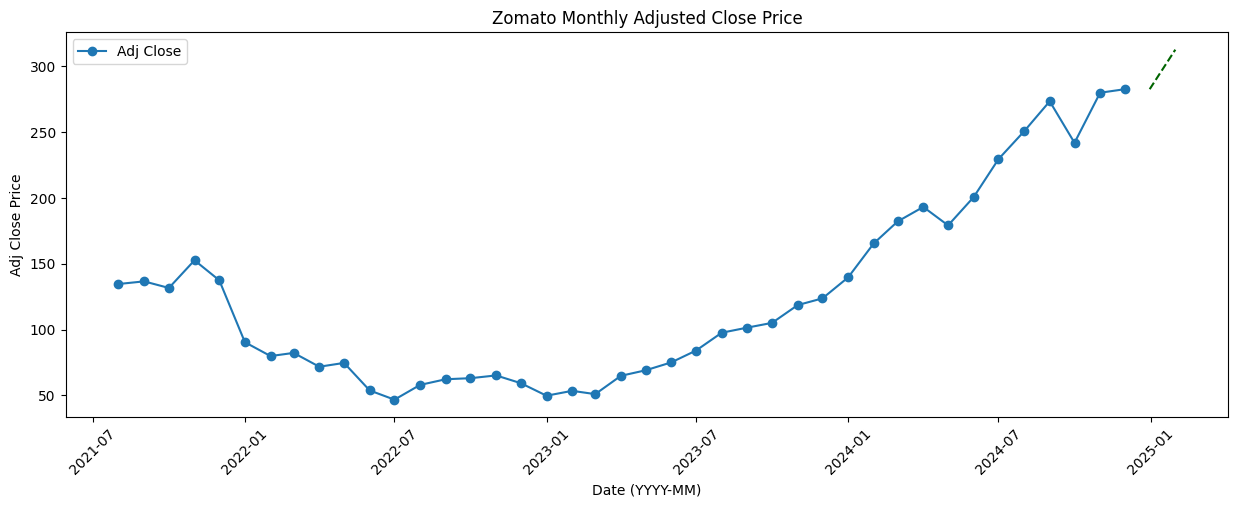

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assume a stock_may_rise value (1 for rise, 0 for decrease)
stock_may_rise = recommendation  # Change to 1 if you want to show rise, 0 for decrease

# Plot the data (Adj Close)
plt.figure(figsize=(15, 5))
plt.plot(df_zomato.index, df_zomato['Adj Close'], marker='o', label='Adj Close')

# Add labels and title
plt.xlabel("Date (YYYY-MM)")
plt.ylabel("Adj Close Price")
plt.title("Zomato Monthly Adjusted Close Price")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()

# Add the line at the end of the graph
last_date = df_zomato.index[-1]
last_price = df_zomato['Adj Close'].iloc[-1]

# Extend the x-axis and create a future line
future_dates = pd.date_range(last_date, periods=2, freq='M')  # One month ahead

if stock_may_rise == 1:
    # If stock may rise, plot a rising line after the last point of the plot
    future_prices = np.linspace(last_price, last_price + 30, num=2)  # Linear increase for the next 1 month
    plt.plot(future_dates, future_prices, color='darkgreen', linestyle='--', label='Potential Rise')

elif stock_may_rise == 0:
    # If stock may decrease, plot a decreasing line after the last point of the plot
    future_prices = np.linspace(last_price, last_price - 30, num=2)  # Linear decrease for the next 1 month
    plt.plot(future_dates, future_prices, color='r', linestyle='--', label='Potential Decrease')

# Show the plot
plt.show()

